In [1]:
from pathlib import Path
import subprocess

REPO_URL = "https://github.com/seoultechpse/fenicsx-colab.git"
ROOT = Path("/content")
REPO_DIR = ROOT / "fenicsx-colab"

subprocess.run(["git", "clone", REPO_URL, str(REPO_DIR)], check=True)

USE_COMPLEX = False  # <--- Set True ONLY if you need complex PETSc
USE_CLEAN = False    # <--- Set True to remove existing environment

opts_str = " ".join(
  [o for c, o in [(USE_COMPLEX, "--complex"), (USE_CLEAN, "--clean")] if c]
)

get_ipython().run_line_magic("run", f"{REPO_DIR / 'setup_fenicsx.py'} {opts_str}")

🔧 FEniCSx Setup Configuration
PETSc type      : real
Clean install   : False

⚠️  Google Drive not mounted — using local cache (/content)

🔧 Installing FEniCSx environment...

🔍 Verifying PETSc type...
✅ Installed: Real PETSc (float64)

✨ Loading FEniCSx Jupyter magic... %%fenicsx registered

✅ FEniCSx setup complete!

Next steps:
  1. Run %%fenicsx --info to verify installation
  2. Use %%fenicsx in cells to run FEniCSx code
  3. Use -np N for parallel execution (e.g., %%fenicsx -np 4)

📌 Note: Real PETSc is installed
   - Recommended for most FEM problems
   - For complex problems, reinstall with --complex


---

In [2]:
%%fenicsx

"""
Finite Element Examples - Code for FEniCS Workshop Slides
==========================================================

This script demonstrates the concepts from "Defining a Finite Element" lecture:
- Creating finite elements using Basix
- Tabulating basis functions
- Visualizing basis functions and derivatives
- Comparing different element types and variants

Author: Kee-Youn Yoo
"""

import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import basix
import basix.ufl

# ============================================================================
# Example 1: Creating a Simple Finite Element
# ============================================================================

print("=" * 70)
print("Example 1: Creating a First Order Lagrange Element on Triangle")
print("=" * 70)

# Create a first order Lagrange element on a triangle
element = basix.ufl.element("Lagrange", "triangle", 1)

print(f"Element family: Lagrange")
print(f"Cell type: triangle")
print(f"Degree: 1")
print(f"Number of DOFs: {element.dim}")
print()

# ============================================================================
# Example 2: Tabulating Basis Functions at Specific Points
# ============================================================================

print("=" * 70)
print("Example 2: Tabulating Basis Functions")
print("=" * 70)

# Define points where we want to evaluate basis functions
points = np.array([
    [0.0, 0.1],   # Point 1
    [0.3, 0.2],   # Point 2
    [0.5, 0.5],   # Point 3 (barycenter)
])

print(f"Evaluation points:\n{points}\n")

# Tabulate basis functions (0th derivative)
values = element.tabulate(0, points)

print(f"Basis function values shape: {values.shape}")
print(f"  (derivatives, points, basis_functions)")
print(f"\nBasis function values at each point:")
for i, point in enumerate(points):
    print(f"  Point {point}: {values[0, i, :]}")
    print(f"    Sum of basis functions: {np.sum(values[0, i, :]):.6f} (should be 1.0)")
print()

# ============================================================================
# Example 3: Computing Derivatives
# ============================================================================

print("=" * 70)
print("Example 3: Computing First Order Derivatives")
print("=" * 70)

# Tabulate with first derivatives
derivatives = element.tabulate(1, points)

print(f"Derivatives shape: {derivatives.shape}")
print(f"  Index 0: function values")
print(f"  Index 1: ∂/∂x derivatives")
print(f"  Index 2: ∂/∂y derivatives\n")

# Show derivatives at first point
point_idx = 0
print(f"At point {points[point_idx]}:")
print(f"  φ values:  {derivatives[0, point_idx, :]}")
print(f"  ∂φ/∂x:     {derivatives[1, point_idx, :]}")
print(f"  ∂φ/∂y:     {derivatives[2, point_idx, :]}")
print()

# ============================================================================
# Example 4: Visualization Function
# ============================================================================

def plot_basis_functions(element, M: int, title_prefix="", output_dir="./figures"):
    """
    Plot the basis functions and first order derivatives.

    Parameters
    ----------
    element : basix element
        The finite element to visualize
    M : int
        Number of sample points along each edge
    title_prefix : str
        Prefix for plot titles
    output_dir : str
        Directory to save figures
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Create uniform sampling points
    points = basix.create_lattice(
        element.cell_type,
        M - 1,
        basix.LatticeType.equispaced,
        exterior=True
    )

    # Tabulate basis functions and derivatives
    values = element.tabulate(1, points)

    num_basis_functions = values.shape[2]
    num_derivatives = values.shape[0]

    derivative_labels = ["phi", "dphi_dx", "dphi_dy"]

    # Create a figure for each basis function
    for basis_idx in range(num_basis_functions):
        fig, axes = plt.subplots(
            1, num_derivatives,
            figsize=(15, 4),
            subplot_kw={'projection': '3d'}
        )

        suptitle = title_prefix + f'Basis Function phi_{basis_idx}'
        fig.suptitle(suptitle, fontsize=14, fontweight='bold')

        for deriv_idx in range(num_derivatives):
            ax = axes[deriv_idx]

            # Plot the values
            scatter = ax.scatter(
                points[:, 0],
                points[:, 1],
                values[deriv_idx, :, basis_idx],
                c=values[deriv_idx, :, basis_idx],
                cmap='viridis',
                s=30
            )

            # Labels
            ax.set_xlabel('x', fontsize=10)
            ax.set_ylabel('y', fontsize=10)
            ax.set_zlabel('value', fontsize=10)
            ax.set_title(derivative_labels[deriv_idx] + f'_{basis_idx}', fontsize=12)

            # Add colorbar
            plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)

        plt.tight_layout()

        # Save figure
        clean_prefix = title_prefix.replace(' ', '_').replace('-', '').lower()
        filename = f"{clean_prefix}basis_function_{basis_idx}.png"
        filepath = os.path.join(output_dir, filename)
        fig.savefig(filepath, dpi=150, bbox_inches='tight')
        print(f"  Saved: {filepath}")
        plt.close(fig)  # Close to free memory

# ============================================================================
# Example 5: Visualize Different Element Types
# ============================================================================

print("=" * 70)
print("Example 5: Visualizing Different Element Types")
print("=" * 70)

# First order triangle
print("Plotting: 1st order Lagrange on triangle...")
element_tri_1 = basix.ufl.element("Lagrange", "triangle", 1)
plot_basis_functions(element_tri_1, 15, "Triangle_P1_")

# Second order triangle
print("Plotting: 2nd order Lagrange on triangle...")
element_tri_2 = basix.ufl.element("Lagrange", "triangle", 2)
plot_basis_functions(element_tri_2, 15, "Triangle_P2_")

# Second order quadrilateral
print("Plotting: 2nd order Lagrange on quadrilateral...")
element_quad_2 = basix.ufl.element("Lagrange", "quadrilateral", 2)
plot_basis_functions(element_quad_2, 12, "Quad_Q2_")

print()

# ============================================================================
# Example 6: Comparing Lagrange Variants
# ============================================================================

print("=" * 70)
print("Example 6: Comparing Lagrange Variants")
print("=" * 70)

# Different variants of 4th order Lagrange on quadrilateral
variants = [
    (basix.LagrangeVariant.equispaced, "Equispaced"),
    (basix.LagrangeVariant.gll_warped, "GLL Warped"),
]

print("Creating 4th order Lagrange elements with different variants:\n")

for variant, name in variants:
    element = basix.ufl.element("Lagrange", "quadrilateral", 4, variant)
    print(f"{name}:")
    print(f"  Number of DOFs: {element.dim}")

    # Sample at a few points
    test_points = np.array([[0.5, 0.5]])
    vals = element.tabulate(0, test_points)
    print(f"  Sum at center point: {np.sum(vals[0, 0, :]):.10f}")
    print()

# ============================================================================
# Example 7: Precision Comparison
# ============================================================================

print("=" * 70)
print("Example 7: Float64 vs Float32 Precision")
print("=" * 70)

# Create elements with different precision
element_f64 = basix.ufl.element("Lagrange", "triangle", 1)
element_f32 = basix.ufl.element("Lagrange", "triangle", 1, dtype=np.float32)

# Test points
test_points_f64 = np.array([[0.0, 0.1], [0.3, 0.2]], dtype=np.float64)
test_points_f32 = test_points_f64.astype(np.float32)

# Tabulate
values_f64 = element_f64.tabulate(0, test_points_f64)
values_f32 = element_f32.tabulate(0, test_points_f32)

print(f"Float64 values:\n{values_f64[0]}")
print(f"  dtype: {values_f64.dtype}\n")

print(f"Float32 values:\n{values_f32[0]}")
print(f"  dtype: {values_f32.dtype}\n")

print(f"Difference:\n{values_f64[0] - values_f32[0]}")
print()

# ============================================================================
# Example 8: Verifying Partition of Unity
# ============================================================================

print("=" * 70)
print("Example 8: Verifying Partition of Unity")
print("=" * 70)

# Create random test points in the reference element
num_test_points = 10
random_points_triangle = np.random.random((num_test_points, 2))

# Keep only points inside the triangle (x + y <= 1)
mask = random_points_triangle[:, 0] + random_points_triangle[:, 1] <= 1.0
valid_points = random_points_triangle[mask]

print(f"Testing partition of unity at {len(valid_points)} random points")

element = basix.ufl.element("Lagrange", "triangle", 2)
values = element.tabulate(0, valid_points)

# Sum of basis functions at each point
sums = np.sum(values[0], axis=1)

print(f"Sum of basis functions at each point:")
for i, (point, s) in enumerate(zip(valid_points, sums)):
    print(f"  Point {i}: {point} -> sum = {s:.15f}")

print(f"\nMax deviation from 1.0: {np.max(np.abs(sums - 1.0)):.2e}")
print()

# ============================================================================
# Example 9: Computing Stiffness Matrix Entry
# ============================================================================

print("=" * 70)
print("Example 9: Computing a Stiffness Matrix Entry")
print("=" * 70)

print("Computing A[0,0] = ∫ ∇φ_0 · ∇φ_0 dx over reference triangle")

element = basix.ufl.element("Lagrange", "triangle", 1)

# Gauss quadrature points for triangle (degree 2)
quad_points = np.array([
    [1/6, 1/6],
    [2/3, 1/6],
    [1/6, 2/3],
])
quad_weights = np.array([1/6, 1/6, 1/6])

# Tabulate gradients
derivs = element.tabulate(1, quad_points)

# Get gradients of φ_0 at quadrature points
# derivs[1] is ∂/∂x, derivs[2] is ∂/∂y
grad_phi0_x = derivs[1, :, 0]
grad_phi0_y = derivs[2, :, 0]

# Compute integral using quadrature
integrand = grad_phi0_x**2 + grad_phi0_y**2
A_00 = np.sum(quad_weights * integrand)

print(f"Quadrature points:\n{quad_points}")
print(f"Quadrature weights: {quad_weights}")
print(f"\n∇φ_0 at quadrature points:")
for i in range(len(quad_points)):
    print(f"  Point {i}: (∂φ/∂x, ∂φ/∂y) = ({grad_phi0_x[i]:.4f}, {grad_phi0_y[i]:.4f})")
print(f"\nA[0,0] = {A_00:.6f}")
print()

# ============================================================================
# Example 10: Element Information
# ============================================================================

print("=" * 70)
print("Example 10: Detailed Element Information")
print("=" * 70)

def print_element_info(element, name):
    """Print detailed information about a finite element."""
    print(f"\n{name}")
    print("-" * 50)
    print(f"Cell type: {element.cell_type}")
    print(f"Degree: {element.degree}")
    print(f"Number of DOFs: {element.dim}")

    # Try to get value shape if available
    try:
        print(f"Value shape: {element.value_shape}")
    except AttributeError:
        print(f"Value shape: (scalar)")

    # Get DOF transformations info
    try:
        entity_dofs = element.entity_dofs
        print(f"\nDOFs per entity:")
        for dim, entities in enumerate(entity_dofs):
            if entities:
                print(f"  Dimension {dim}: {entities}")
    except AttributeError:
        # For some element types, entity_dofs might not be available
        pass

# Print info for various elements
elements_to_inspect = [
    (basix.ufl.element("Lagrange", "triangle", 1), "P1 Triangle"),
    (basix.ufl.element("Lagrange", "triangle", 2), "P2 Triangle"),
    (basix.ufl.element("Lagrange", "quadrilateral", 2), "Q2 Quadrilateral"),
    (basix.ufl.element("Lagrange", "tetrahedron", 1), "P1 Tetrahedron"),
]

for elem, name in elements_to_inspect:
    print_element_info(elem, name)

print("\n" + "=" * 70)
print("All examples completed!")
print("All figures have been saved to './figures/' directory")
print("=" * 70)

Example 1: Creating a First Order Lagrange Element on Triangle
Element family: Lagrange
Cell type: triangle
Degree: 1
Number of DOFs: 3

Example 2: Tabulating Basis Functions
Evaluation points:
[[0.  0.1]
 [0.3 0.2]
 [0.5 0.5]]

Basis function values shape: (1, 3, 3)
  (derivatives, points, basis_functions)

Basis function values at each point:
  Point [0.  0.1]: [9.00000000e-01 5.55111512e-17 1.00000000e-01]
    Sum of basis functions: 1.000000 (should be 1.0)
  Point [0.3 0.2]: [0.5 0.3 0.2]
    Sum of basis functions: 1.000000 (should be 1.0)
  Point [0.5 0.5]: [0.  0.5 0.5]
    Sum of basis functions: 1.000000 (should be 1.0)

Example 3: Computing First Order Derivatives
Derivatives shape: (3, 3, 3)
  Index 0: function values
  Index 1: ∂/∂x derivatives
  Index 2: ∂/∂y derivatives

At point [0.  0.1]:
  φ values:  [9.00000000e-01 5.55111512e-17 1.00000000e-01]
  ∂φ/∂x:     [-1.00000000e+00  1.00000000e+00 -4.30845614e-17]
  ∂φ/∂y:     [-1.  0.  1.]

Example 5: Visualizing Different

Finite Element Basis Function Visualization

### Option 1: List Available Figures ###

Found 18 figures in './figures':

Quad Q2:
  - quad_q2_basis_function_0.png
  - quad_q2_basis_function_1.png
  - quad_q2_basis_function_2.png
  - quad_q2_basis_function_3.png
  - quad_q2_basis_function_4.png
  - quad_q2_basis_function_5.png
  - quad_q2_basis_function_6.png
  - quad_q2_basis_function_7.png
  - quad_q2_basis_function_8.png

Triangle P1:
  - triangle_p1_basis_function_0.png
  - triangle_p1_basis_function_1.png
  - triangle_p1_basis_function_2.png

Triangle P2:
  - triangle_p2_basis_function_0.png
  - triangle_p2_basis_function_1.png
  - triangle_p2_basis_function_2.png
  - triangle_p2_basis_function_3.png
  - triangle_p2_basis_function_4.png
  - triangle_p2_basis_function_5.png


### Option 2: Display All Figures Individually ###
(Uncomment to use)


### Option 3: Display Figures Grouped by Element Type ###

Element Type: quad_q2

Basis Function: quad_q2_basis_function_0


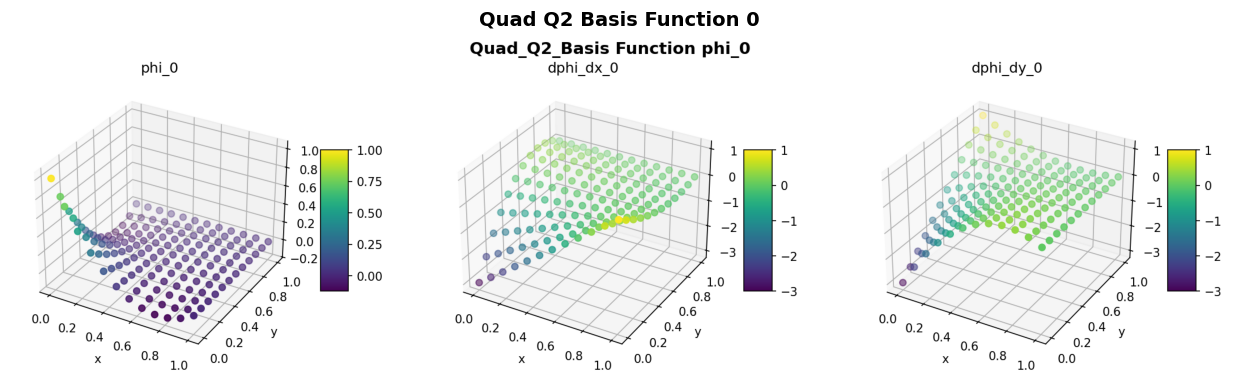


Basis Function: quad_q2_basis_function_1


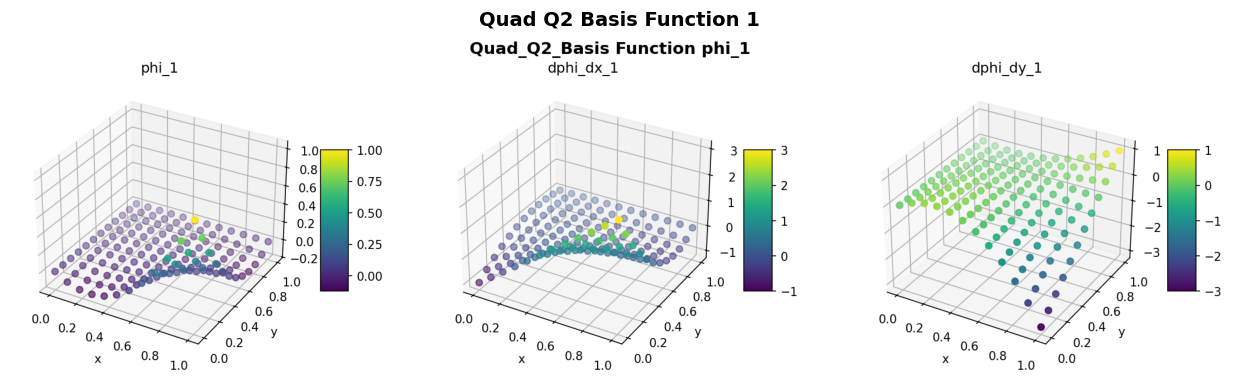


Basis Function: quad_q2_basis_function_2


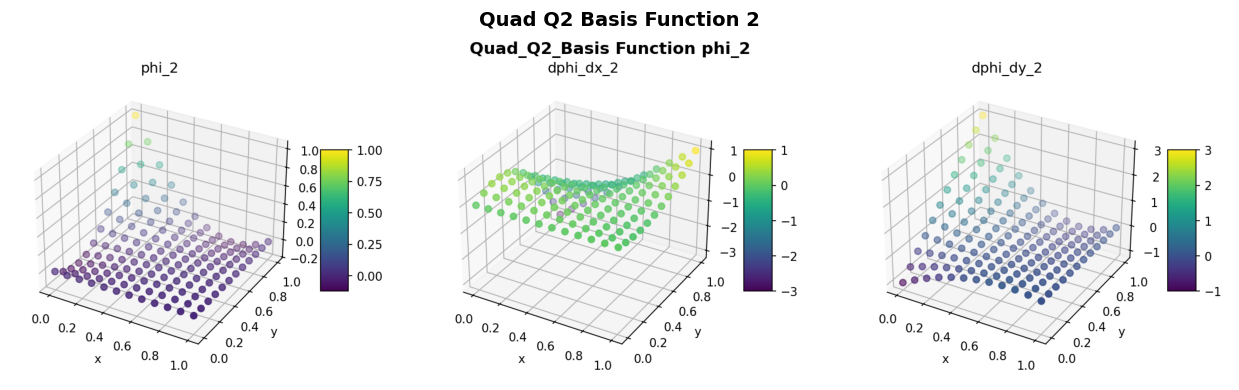


Basis Function: quad_q2_basis_function_3


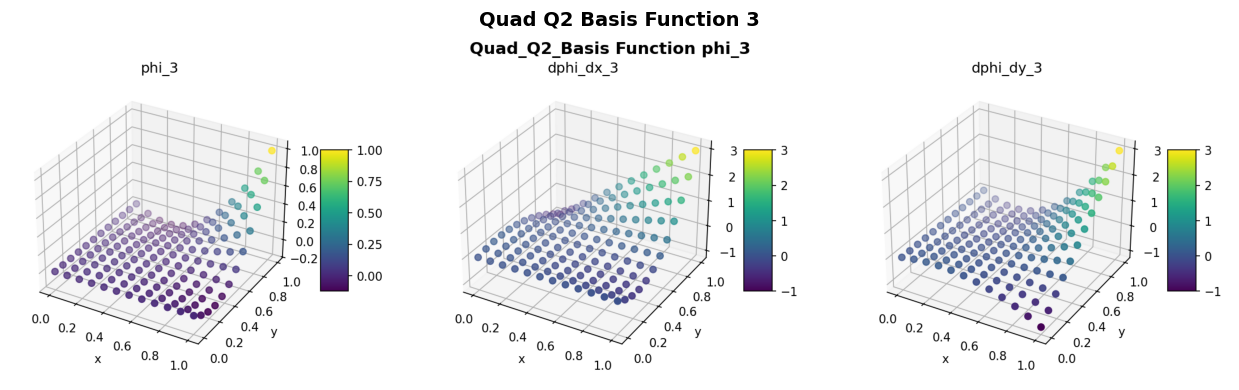


Basis Function: quad_q2_basis_function_4


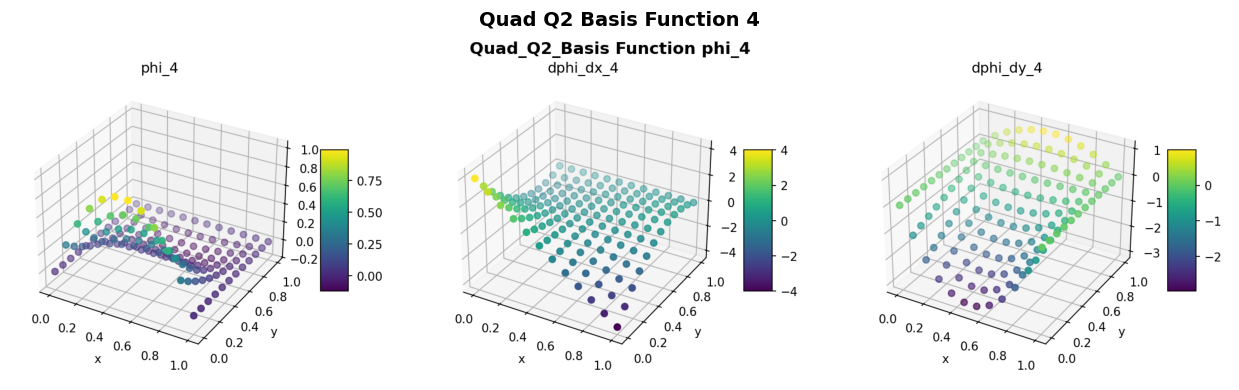


Basis Function: quad_q2_basis_function_5


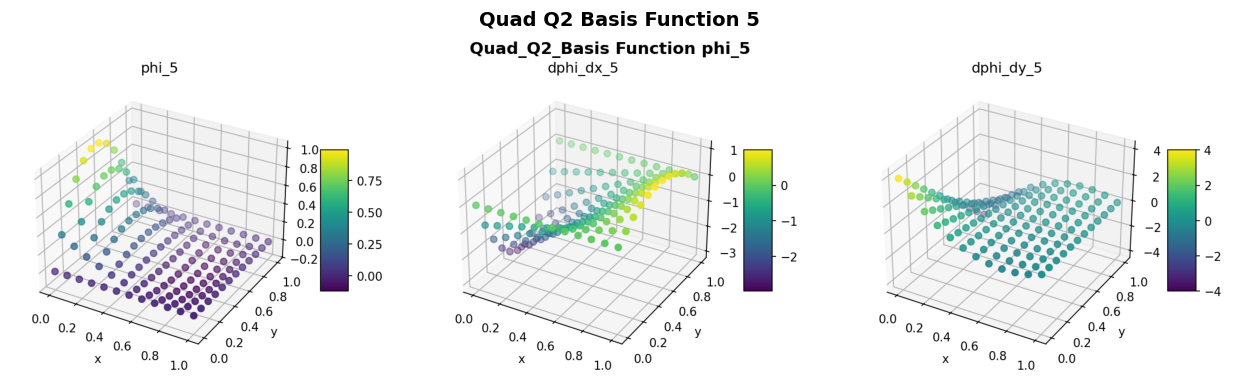


Basis Function: quad_q2_basis_function_6


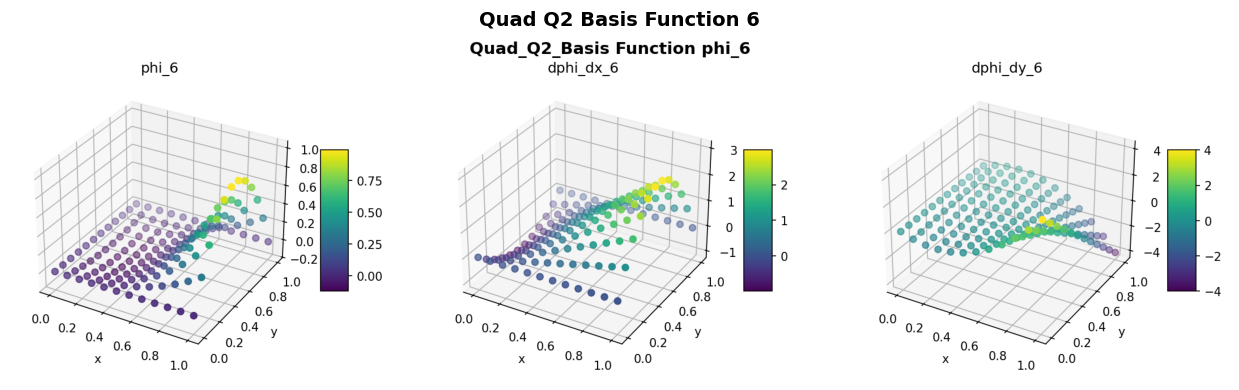


Basis Function: quad_q2_basis_function_7


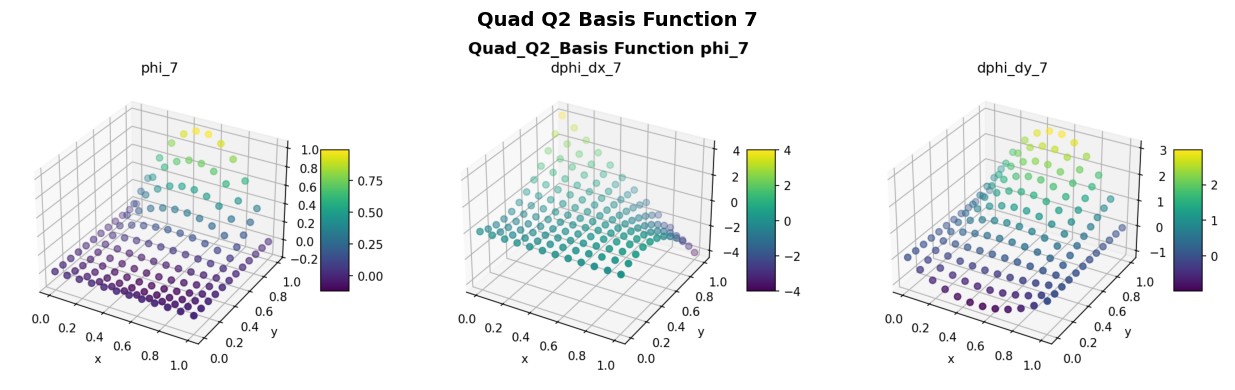


Basis Function: quad_q2_basis_function_8


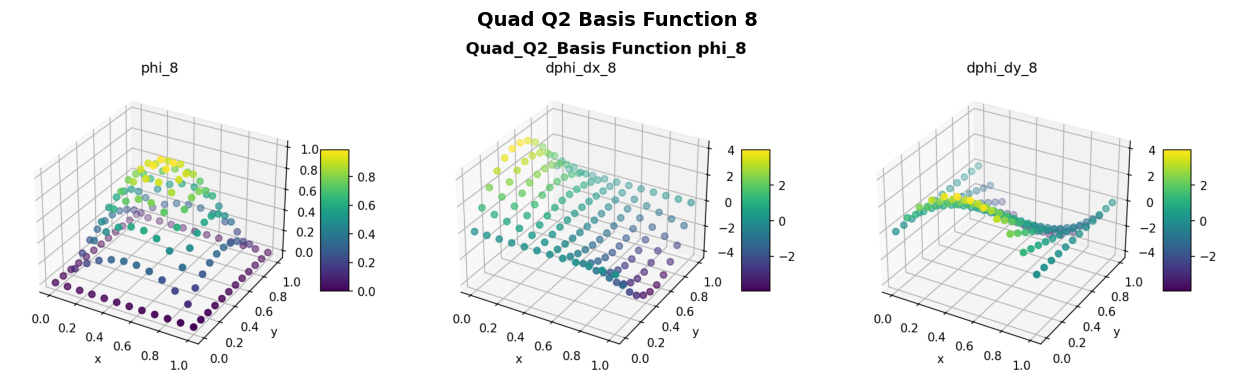


Element Type: triangle_p1

Basis Function: triangle_p1_basis_function_0


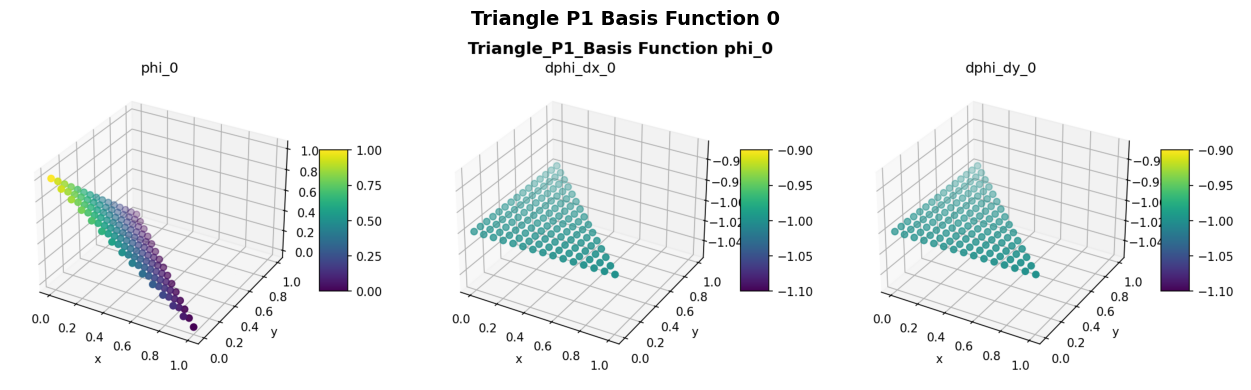


Basis Function: triangle_p1_basis_function_1


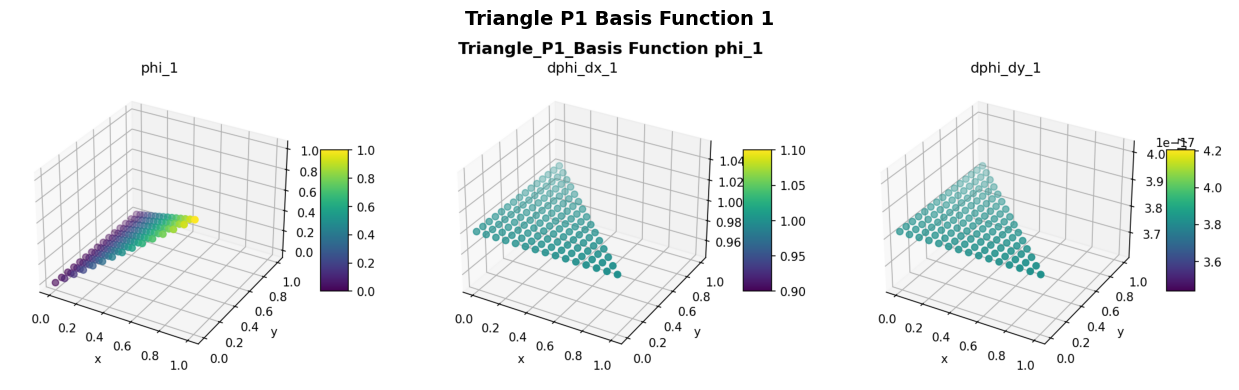


Basis Function: triangle_p1_basis_function_2


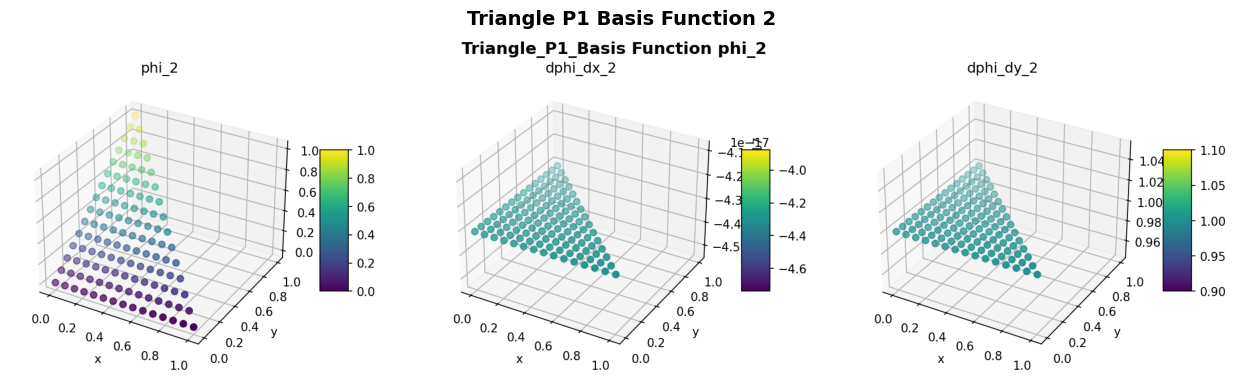


Element Type: triangle_p2

Basis Function: triangle_p2_basis_function_0


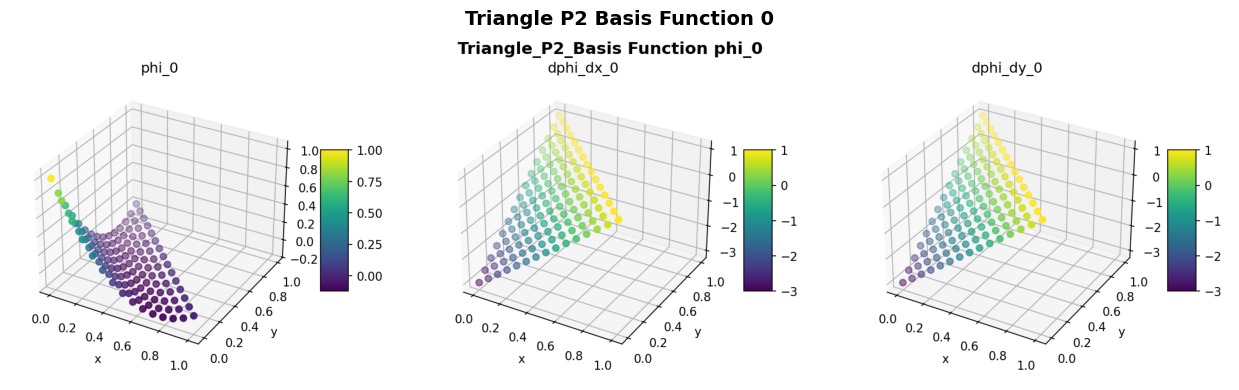


Basis Function: triangle_p2_basis_function_1


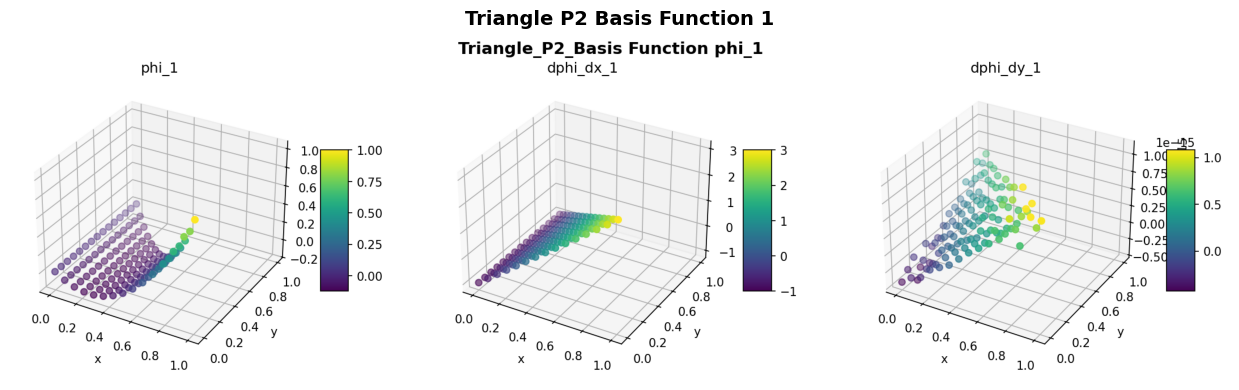


Basis Function: triangle_p2_basis_function_2


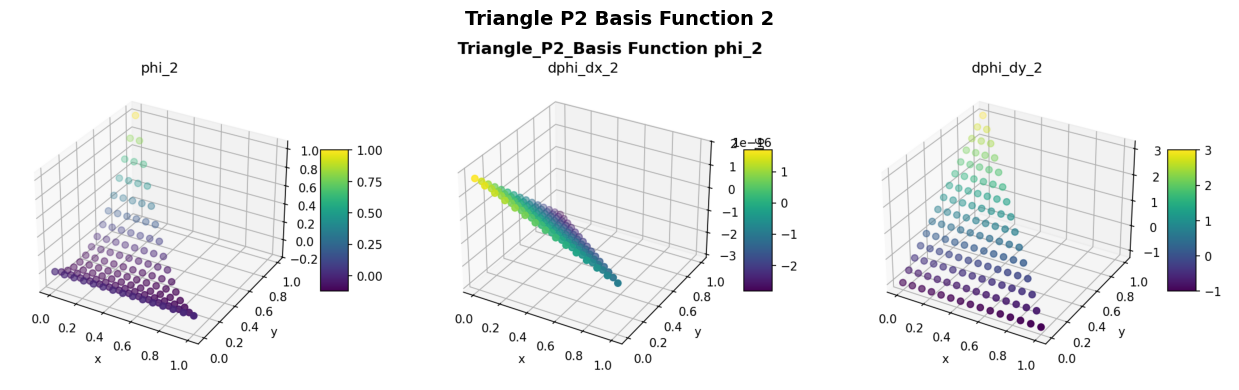


Basis Function: triangle_p2_basis_function_3


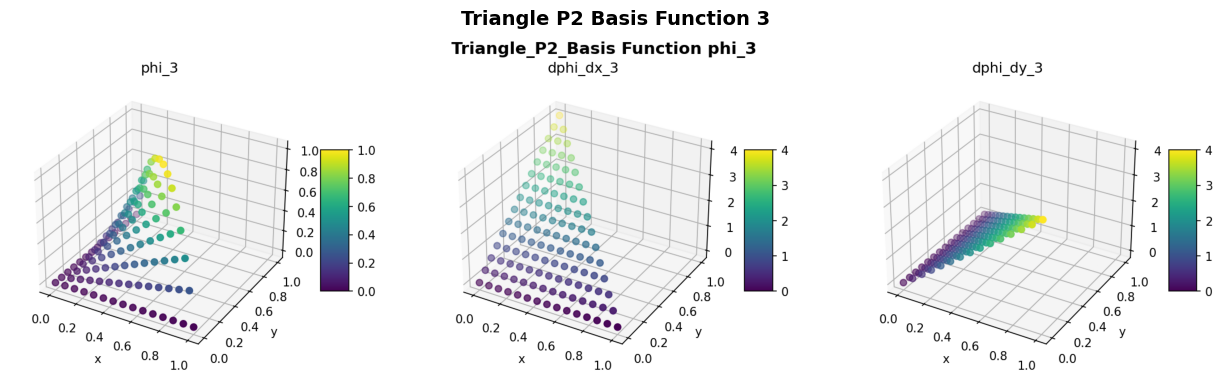


Basis Function: triangle_p2_basis_function_4


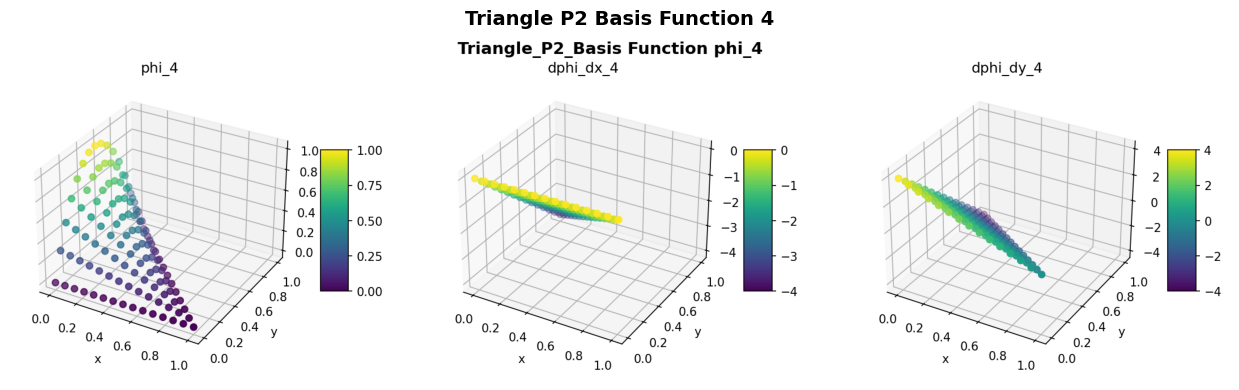


Basis Function: triangle_p2_basis_function_5


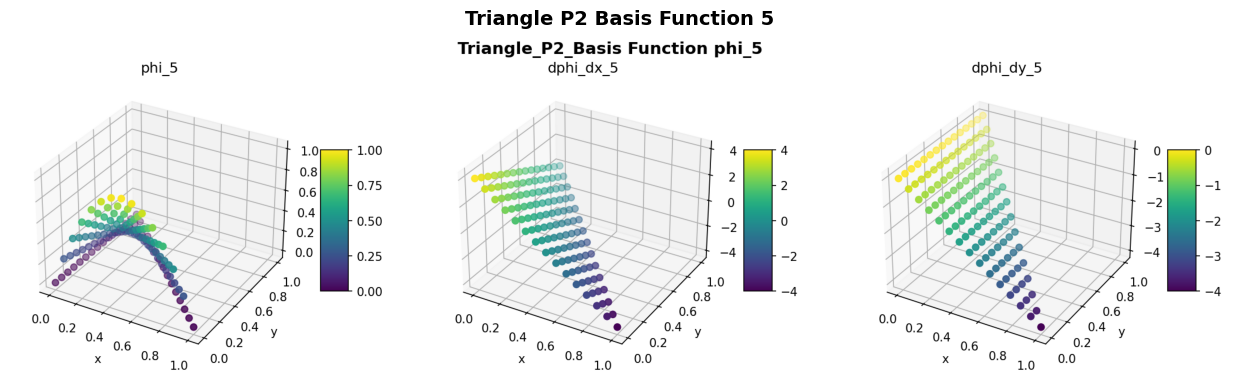



### Option 4: Display Figures in Compact Grid ###
(Uncomment to use)


### Option 5: Display Specific Element Type ###
(Uncomment and modify element_type to use)


In [3]:
"""
Display Saved Figures in Google Colab
======================================

This script loads and displays all saved finite element visualizations
in an organized manner for Google Colab notebooks.

Author: FEniCS Workshop
"""

import os
import matplotlib.pyplot as plt
from matplotlib.image import imread
from pathlib import Path
import numpy as np

def display_all_figures(figures_dir="./figures", cols=3):
    """
    Display all saved figures from a directory in a grid layout.

    Parameters
    ----------
    figures_dir : str
        Directory containing saved figures
    cols : int
        Number of columns in the grid layout
    """
    # Get all PNG files
    figure_path = Path(figures_dir)
    if not figure_path.exists():
        print(f"Error: Directory '{figures_dir}' does not exist!")
        return

    image_files = sorted(list(figure_path.glob("*.png")))

    if not image_files:
        print(f"No PNG files found in '{figures_dir}'")
        return

    print(f"Found {len(image_files)} figures in '{figures_dir}'")
    print("=" * 70)

    # Display all images
    for img_file in image_files:
        print(f"\nDisplaying: {img_file.name}")
        img = imread(img_file)

        plt.figure(figsize=(15, 4))
        plt.imshow(img)
        plt.axis('off')
        plt.title(img_file.stem, fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()


def display_figures_by_element(figures_dir="./figures"):
    """
    Display figures grouped by element type.

    Parameters
    ----------
    figures_dir : str
        Directory containing saved figures
    """
    figure_path = Path(figures_dir)
    if not figure_path.exists():
        print(f"Error: Directory '{figures_dir}' does not exist!")
        return

    image_files = sorted(list(figure_path.glob("*.png")))

    if not image_files:
        print(f"No PNG files found in '{figures_dir}'")
        return

    # Group files by element type (prefix before 'basis_function')
    from collections import defaultdict
    grouped_files = defaultdict(list)

    for img_file in image_files:
        # Extract element type from filename
        name = img_file.stem
        if 'basis_function' in name:
            element_type = name.split('basis_function')[0].rstrip('_')
            grouped_files[element_type].append(img_file)
        else:
            grouped_files['other'].append(img_file)

    # Display each group
    for element_type, files in sorted(grouped_files.items()):
        print("\n" + "=" * 70)
        print(f"Element Type: {element_type}")
        print("=" * 70)

        for img_file in sorted(files):
            print(f"\nBasis Function: {img_file.stem}")
            img = imread(img_file)

            plt.figure(figsize=(15, 4))
            plt.imshow(img)
            plt.axis('off')
            plt.title(img_file.stem.replace('_', ' ').title(),
                     fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()


def display_figures_grid(figures_dir="./figures", max_per_group=9):
    """
    Display figures in a compact grid layout, grouped by element type.

    Parameters
    ----------
    figures_dir : str
        Directory containing saved figures
    max_per_group : int
        Maximum number of figures to display per element type
    """
    figure_path = Path(figures_dir)
    if not figure_path.exists():
        print(f"Error: Directory '{figures_dir}' does not exist!")
        return

    image_files = sorted(list(figure_path.glob("*.png")))

    if not image_files:
        print(f"No PNG files found in '{figures_dir}'")
        return

    # Group files by element type
    from collections import defaultdict
    grouped_files = defaultdict(list)

    for img_file in image_files:
        name = img_file.stem
        if 'basis_function' in name:
            element_type = name.split('basis_function')[0].rstrip('_')
            grouped_files[element_type].append(img_file)
        else:
            grouped_files['other'].append(img_file)

    # Display each group in a grid
    for element_type, files in sorted(grouped_files.items()):
        print("\n" + "=" * 70)
        print(f"Element Type: {element_type.replace('_', ' ').title()}")
        print("=" * 70)

        num_images = min(len(files), max_per_group)
        files_to_show = sorted(files)[:num_images]

        # Calculate grid size
        cols = 3
        rows = (num_images + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
        fig.suptitle(f'{element_type.replace("_", " ").title()} - Basis Functions',
                     fontsize=16, fontweight='bold')

        # Flatten axes for easier indexing
        if rows == 1:
            axes = axes.reshape(1, -1)
        axes = axes.flatten()

        for idx, img_file in enumerate(files_to_show):
            img = imread(img_file)
            axes[idx].imshow(img)
            axes[idx].axis('off')

            # Extract basis function number
            basis_num = img_file.stem.split('_')[-1]
            axes[idx].set_title(f'Basis Function {basis_num}',
                               fontsize=10, fontweight='bold')

        # Hide unused subplots
        for idx in range(num_images, len(axes)):
            axes[idx].axis('off')

        plt.tight_layout()
        plt.show()

        if len(files) > max_per_group:
            print(f"  (Showing {num_images} of {len(files)} basis functions)")


def list_available_figures(figures_dir="./figures"):
    """
    List all available figures without displaying them.

    Parameters
    ----------
    figures_dir : str
        Directory containing saved figures
    """
    figure_path = Path(figures_dir)
    if not figure_path.exists():
        print(f"Error: Directory '{figures_dir}' does not exist!")
        return

    image_files = sorted(list(figure_path.glob("*.png")))

    if not image_files:
        print(f"No PNG files found in '{figures_dir}'")
        return

    print(f"\nFound {len(image_files)} figures in '{figures_dir}':")
    print("=" * 70)

    # Group by element type
    from collections import defaultdict
    grouped_files = defaultdict(list)

    for img_file in image_files:
        name = img_file.stem
        if 'basis_function' in name:
            element_type = name.split('basis_function')[0].rstrip('_')
            grouped_files[element_type].append(img_file)
        else:
            grouped_files['other'].append(img_file)

    for element_type, files in sorted(grouped_files.items()):
        print(f"\n{element_type.replace('_', ' ').title()}:")
        for img_file in sorted(files):
            print(f"  - {img_file.name}")


def display_single_element_type(element_type, figures_dir="./figures"):
    """
    Display all basis functions for a specific element type.

    Parameters
    ----------
    element_type : str
        Element type prefix (e.g., 'Triangle_P1', 'Quad_Q2')
    figures_dir : str
        Directory containing saved figures
    """
    figure_path = Path(figures_dir)
    if not figure_path.exists():
        print(f"Error: Directory '{figures_dir}' does not exist!")
        return

    # Find all files matching the element type
    pattern = f"{element_type}_basis_function_*.png"
    image_files = sorted(list(figure_path.glob(pattern)))

    if not image_files:
        print(f"No figures found for element type '{element_type}'")
        print(f"Pattern searched: {pattern}")
        return

    print(f"\n{'=' * 70}")
    print(f"Displaying {len(image_files)} basis functions for: {element_type}")
    print('=' * 70)

    for img_file in image_files:
        print(f"\n{img_file.name}")
        img = imread(img_file)

        plt.figure(figsize=(15, 4))
        plt.imshow(img)
        plt.axis('off')

        # Extract basis function number
        basis_num = img_file.stem.split('_')[-1]
        plt.title(f'{element_type.replace("_", " ")} - Basis Function {basis_num}',
                 fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()


# ============================================================================
# Main Display Options
# ============================================================================

if __name__ == "__main__":
    print("=" * 70)
    print("Finite Element Basis Function Visualization")
    print("=" * 70)

    # Option 1: List all available figures
    print("\n### Option 1: List Available Figures ###")
    list_available_figures()

    # Option 2: Display all figures one by one
    print("\n\n### Option 2: Display All Figures Individually ###")
    print("(Uncomment to use)")
    # display_all_figures()

    # Option 3: Display figures grouped by element type
    print("\n\n### Option 3: Display Figures Grouped by Element Type ###")
    display_figures_by_element()

    # Option 4: Display figures in compact grid layout
    print("\n\n### Option 4: Display Figures in Compact Grid ###")
    print("(Uncomment to use)")
    # display_figures_grid()

    # Option 5: Display specific element type
    print("\n\n### Option 5: Display Specific Element Type ###")
    print("(Uncomment and modify element_type to use)")
    # display_single_element_type('Triangle_P1')
    # display_single_element_type('Triangle_P2')
    # display_single_element_type('Quad_Q2')